In [142]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
import scipy.io as sio
import scipy.stats.qmc as qmc
import pandas as pd

# Preprocessing

In [129]:
## DEFINE INPUT PARAMETERS
# defining velocity, density, and viscocity for fluid
u0 = 1 # lid velocity
rho0 = 1
nu0 = 0.01
N = 4400 # number of collocation data points [x,y]

In [130]:
def Uniform_with_Cylinder(u0, N_col=4000, N_BC=500, N_circ=400, r=0.5):
    """
    Create collocation points inside a 1by1 box with a cylinder in the middle

    Args:
        u0 : Inlet velocity
        N_col : number of collocation points # note the acc number is slightly less as we are removing points in the cylinder
        N_circ : Number of points along cylinder boundary
        r : Cylinder radius 
    
    Returns: 
        Tensors of:
        X_col : Collocation points [x, y]
        BC_X : Boundary points [x, y]
        BC_Y : Boundary condition values [u, v]
    """

    # setting up domain size
    xc, yc = 0, 0  # cylinder center

    # CREATING collocation points
    # set random points across the domain using the random normal distribution function hence *3 or *10 to change standard dev and get distribution centred round cylinder
    y = 2*np.random.randn(N_col,1)
    x = 4*np.random.randn(N_col,1)
    
    xy = np.hstack((x, y))  
    

    # Distance from cylinder center
    dist = np.sqrt((xy[:, 0] - xc)**2 + (xy[:, 1] - yc)**2)

    # Keep only points outside the cylinder. Boolean mask for cylinder and BCs
    valid_col = (dist > r) & (xy[:,0]>-10) & (xy[:,1]>-7) & (xy[:,1]< 7)
    xy_outside = xy[valid_col]

    X_col = torch.tensor(xy_outside, dtype=torch.float32)

    # CREATING Boundary condition locations
    # domain currently set y = -7 to 7 : x = -10 to 25

    # evenly distribute BC points along the sides
    # N_BC = int(np.sqrt(N_col) // 2)
    y = np.linspace(-7, 7, N_BC)
    x = np.linspace(-10, 35, N_BC)

    # turn those points into x,y co-ords
    b_left   = np.column_stack([(np.ones_like(y)*-10), y])
    b_right  = np.column_stack([np.ones_like(y)*35, y])
    b_bottom = np.column_stack([x, np.ones_like(x)*-7])
    b_top    = np.column_stack([x, np.ones_like(x)*7])

    # cylinder BCs
    theta = np.linspace(0, 2*np.pi, N_circ)
    cylinder_x = (r * np.cos(theta) + xc)
    cylinder_y = (r * np.sin(theta) + yc)
    cylinder_xy = np.column_stack([cylinder_x, cylinder_y])

    # Add all BC points
    BC_X_np = np.vstack([b_left, cylinder_xy])
    BC_X = torch.tensor(BC_X_np, dtype=torch.float32)

    # CREATING the BC_Y essentially 0s everywhere except inlet
    # tensor of zeros for all walls except inlet
    # walls_Y = torch.zeros_like(torch.tensor(np.vstack([b_top, b_bottom, b_right]), dtype=torch.float32))

    # inlet velocity
    inlet = torch.zeros_like(torch.tensor(b_left, dtype=torch.float32))
    inlet[:, 0] = u0

    # Cylinder no slip so 0
    cylinder_uv = torch.zeros_like(torch.tensor(cylinder_xy, dtype=torch.float32))

    # Combine boundary velocities
    BC_Y = torch.cat([inlet, cylinder_uv], dim=0)

    return X_col, BC_X, BC_Y

def Data(N=1000):
    engine = qmc.LatinHypercube(d=1)
    """
    loads data from benchmark file

    Args:
        
    Returns: As Tensors (dim = Nx2)
        X_D   : coordinates of data points [x,y] for u,v, dim = [N*2]
        U_D   : training output [u*, v*] at data points X_D, dim = [N*2] 
        PXY_D : coordinates of data points [x,y] for p, dim = [N*2]
        P_D   : training output [p*] at data points PXY_D
    Notes about data:
        - flow around a cylinder
        - Re = 100 , all data has been non-dimensionalised?? , inlet velocity u = 1
    """
    

    ## Read file holding training data
    xy_data = sio.loadmat("Cyl100_Sean/xstar.mat")
    uv_data = sio.loadmat("Cyl100_Sean/ustar_Aug24.mat") 
    # pressure is calculated at different data points
    p_data  = sio.loadmat("Cyl100_Sean/pstar.mat")
    pxy_data  = sio.loadmat("Cyl100_Sean/xpstar.mat")
    
    uv_data_np = np.array(uv_data["ustar"][:,:,0])
    u_np = uv_data_np[:,0]
    v_np = uv_data_np[:,1]
    
    xy_data_np = np.array(xy_data["xstar"])
    x_np = xy_data_np[:,0]
    y_np = xy_data_np[:,1]

    p_data_np = np.array(p_data["pstar"])
    pxy_data_np = np.array(pxy_data["xpstar"])

    # Generate indicies of random points in dataset
    idx = engine.integers(l_bounds=0, u_bounds=len(x_np), n=N)
    p_idx = engine.integers(l_bounds=0, u_bounds=len(pxy_data_np))
    
    x = torch.tensor(x_np[idx], dtype=torch.float32)
    y = torch.tensor(y_np[idx], dtype=torch.float32)
    u = torch.tensor(u_np[idx], dtype=torch.float32)
    v = torch.tensor(v_np[idx], dtype=torch.float32)
    

    X_D = torch.column_stack((x, y))
    U_D = torch.column_stack((u,v))
    PXY_D = torch.tensor(pxy_data_np[p_idx], dtype=torch.float32)
    P_D   = torch.tensor(p_data_np[:,0:1][p_idx], dtype=torch.float32)

    #print(X_D.size(), U_D.size(),PXY_D.shape(), P_D.shape())
    #print(PXY_D.size(), P_D.size())
    return X_D, U_D, PXY_D, P_D

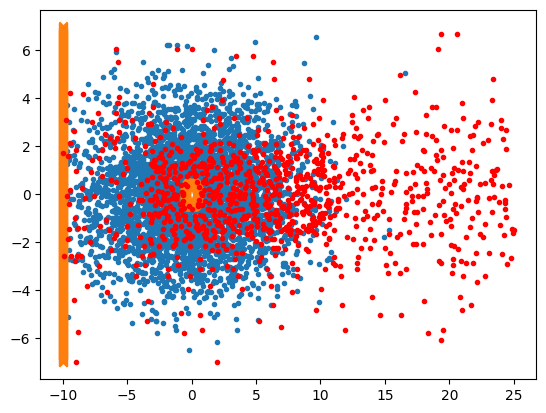

In [131]:
X_col, BC_X, BC_Y= Uniform_with_Cylinder(1)
X_D, U_D, PXY_D, P_D = Data()
plt.scatter(X_col[:,0].numpy(),X_col[:,1].numpy(),marker='.')
plt.scatter(BC_X[:,0].numpy(),BC_X[:,1].numpy(),marker='x')
plt.scatter(X_D[:,0].numpy(), X_D[:,1].numpy(),marker='.', color='r')
#plt.xlim(-2,5)
#plt.ylim(-2,2)

In [132]:
## Compute gradients
def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        retain_graph=True
    )[0]
def compute_gradients(model, xy):
    """
    Args:
        model : PyTorch neural network, with three models inside it (u,v and p) for input xy
        xy    : tensor of shape (N, 2), # when setting up model set requires_grad=True

    Returns:
        p_grads : (p, p_x, p_y) as a tuple
        u_grads : (u, u_x, u_y, u_xx, u_yy) as a tuple
        v_grads : (v, v_x, v_y, v_xx, v_yy) as a tuple
    """
    # create a clone so we dont change the original tensor
    # detatch the xy data from previous gradients so it can be evaluated in isolation
    xy = xy.clone().detach().requires_grad_(True)  
    x = xy[:, 0:1]
    y = xy[:, 1:2]

    # Make a fwd pass that goes through the combined mini models collecting all coefficients needed for derivatives
    u_v_p = model(torch.cat([x, y], dim=1))
    u = u_v_p[:,0:1]
    v = u_v_p[:,1:2]
    p = u_v_p[:,2:3]

    
    # First-order derivatives
    p_x = grad(p, x)
    p_y = grad(p, y)

    # Second-order derivatives
    u_x = grad(u, x)
    u_y = grad(u, y)
    v_x = grad(v, x)
    v_y = grad(v, y)

    # Third-order derivatives
    u_xx = grad(u_x, x)
    u_yy = grad(u_y, y)
    v_xx = grad(v_x, x)
    v_yy = grad(v_y, y)
    
    p_grads = (p, p_x, p_y)
    u_grads = (u, u_x, u_y, u_xx, u_yy)
    v_grads = (v, v_x, v_y, v_xx, v_yy)

    return p_grads, u_grads, v_grads

# Model Creation

In [133]:
## LOSS EQUATIONS
def navier_stokes_loss(model,X):
    """
    calculates steady navier stokes residuals at collocation points

    Args: 
        model : whatever model calls this function
        X : input collocation [x,y] coords as defined in models data creation

    Returns: 
        tensor of all collocation point residuals
    """
    p_grads, u_grads, v_grads = compute_gradients(model, X)
    _, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads

    #compute PDE residuals
    u_eqn = u*u_x + v*u_y + p_x/rho0 - nu0*(u_xx + u_yy)
    v_eqn = u*v_x + v*v_y + p_y/rho0 - nu0*(v_xx + v_yy)
    

    # combine into one tensor
    # [u_residual, v_residual, continuity]
    return torch.cat([u_eqn, v_eqn,(u_x+v_y)], dim=1)
    
def BC_loss(model,BC_X):
    """
    calculates u and v at boundary conditions

    Args: 
        model : whatever model calls this function
        BC_X : Input Boundary conditions [x,y] coords as defined in models data creation
        
    Returns: 
        tensor of u,v at all boundary condition coords
    """
    _, u_grads, v_grads = compute_gradients(model,BC_X)
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads
    return torch.cat([u, v], dim=1)
def UV_Data_loss(model, X_D):
    p_grads, u_grads, v_grads = compute_gradients(model,X_D)
    p, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads
    
    return torch.cat([u, v], dim=1)
def P_Data_loss(model, PXY_D):
    p_grads, u_grads, v_grads = compute_gradients(model,PXY_D)
    p, p_x, p_y = p_grads
    u, u_x, u_y, u_xx, u_yy = u_grads
    v, v_x, v_y, v_xx, v_yy = v_grads

    # solution need to use torch.cat rather then torch.tensor to create p data loss as it retains the gradient computation graph whilst torch.tensor performs a .detach()
    pval = torch.cat([p], dim=1)
    
    return pval

## Define sub models and combine into 1 model

In [134]:
## CREATING THE MINI MODEL FOR u,v AND p AND THEN COMBINE THEM INTO ONE MODEL

# sub model for u,v and p 
class submodel(nn.Module):
    def __init__(
            self,
            N_input,
            N_hidden_arr,
            N_output,
            activation = nn.Tanh
    ):
        super(submodel, self).__init__()  # Create network

        # Create input layer w/ activation function
        layers = [('Input', nn.Linear(N_input, N_hidden_arr[0]))]
        layers.append(('Input activation', activation()))

        # Create hidden layers
        for i in range(len(N_hidden_arr)-1):
            layers.append(
                ("Hidden %d" % (i+1), nn.Linear(N_hidden_arr[i], N_hidden_arr[i+1]))
            )
            layers.append(('Hidden activation %d' % (i+1), activation()))
        layers.append(('Output', nn.Linear(N_hidden_arr[-1], N_output)))
        layerdict = OrderedDict(layers)
        self.layers = nn.Sequential(layerdict)

    def forward(self, x):
        y = self.layers(x)
        return y


class Net(nn.Module):
    def __init__(self, N_input, N_hidden_arr, N_output, activation = nn.Tanh):
        
        super(Net, self).__init__()  # Create network
        # creates three models using submodel as the blueprint
        self.model_u = submodel(N_input, N_hidden_arr ,N_output, activation)
        self.model_v = submodel(N_input, N_hidden_arr, N_output, activation)
        self.model_p = submodel(N_input, N_hidden_arr, N_output, activation)


    # combine the outputs of all the models into a single output
    def forward(self, xy):
        out_u = self.model_u(xy)
        out_v = self.model_v(xy)
        out_p = self.model_p(xy)
        combined = torch.cat((out_u, out_v, out_p), dim=1)
        return combined


        

## Defining the model

In [135]:
## create neural network

class PINN:
    def __init__(self):
        ### Need to change this to check if gpu available as well
        device = torch.device("cpu")
        print("Using CPU")
        self.model = Net(
            N_input=2,
            N_hidden_arr=[32,16,16,32],
            N_output = 1
        ).to(device)
    
        # DATA CREATION 
        self.X, self.BC_X, self.BC_Y =  Uniform_with_Cylinder(u0)
        self.X_D, self.U_D, self.PXY_D, self.P_D = Data()

        # copy and seperate tensors into format for loss calculations
        self.X    = self.X.clone().detach().requires_grad_(True)
        self.BC_X = self.BC_X.clone().detach().requires_grad_(True)

        self.X_D   = self.X_D.clone().detach().requires_grad_(True)
        self.PXY_D = self.PXY_D.clone().detach().requires_grad_(True)
        
        # OPTIMISERS
        self.optimiser = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=1.0,
            max_iter = 25*10**3,
            max_eval = 25*10**3,
            history_size=50,
            tolerance_change=1e-7,
            tolerance_grad=1e-7,
            line_search_fn="strong_wolfe"
        )
        self.adam = torch.optim.Adam(self.model.parameters())

        
        self.loss_fn = nn.MSELoss()

        # Counter for printing loss
        self.iter =1
        
    # Loss
    def compute_loss(self, epoch_split=500):


        # Data Loss
        uv_data_loss = UV_Data_loss(self.model, self.X_D)
        uv_data_loss = self.loss_fn(uv_data_loss, self.U_D)
        
        p_data_loss  = P_Data_loss(self.model, self.PXY_D)
        p_data_loss = self.loss_fn(p_data_loss, self.P_D)

        data_loss = p_data_loss+uv_data_loss
        pde_loss = bc_loss = 0
        if self.iter >= epoch_split:
            residuals = navier_stokes_loss(self.model, self.X)
            ru, rv, conservation  = residuals[:, 0:1], residuals[:, 1:2], residuals[:, 2:3]

            # PDE loss (residuals against tensor of zeros)
            pde_loss = self.loss_fn(ru, torch.zeros_like(ru)) + self.loss_fn(rv, torch.zeros_like(rv))+self.loss_fn(conservation, torch.zeros_like(conservation))

            # BC loss
            bc_loss = BC_loss(self.model,self.BC_X)
            bc_loss = self.loss_fn(bc_loss,self.BC_Y)
            # Evaluate losses only on steps when they are necessary to save computational load
            # Compute PDE residuals at collocation points
            
        total_loss = data_loss+pde_loss+bc_loss
        
        if self.iter >= epoch_split:
            alt_hist = [data_loss.item(), uv_data_loss.item(), p_data_loss.item(), pde_loss.item(), bc_loss.item()]
            if self.iter % 100 == 0:
                print(f"Iteration {self.iter:5}, Total Loss {total_loss:.9f}, Data loss {data_loss:.9f} = uv data loss: {uv_data_loss} + p data loss: {p_data_loss} ,pde loss {pde_loss:.9f}, BC loss {bc_loss:.9f}")                
        else:
            alt_hist = [data_loss.item(), uv_data_loss.item(), p_data_loss.item()]
            if self.iter % 100 == 0:
                print(f"Iteration: {self.iter:5}, Total Loss {total_loss:.9f}, Data loss {data_loss:.9f} = uv data loss: {uv_data_loss} + p data loss: {p_data_loss}")
            
        self.iter+= 1
        
        return total_loss, alt_hist
    
    def train(self, adam_epochs=300, lbfgs_epochs=10, epoch_split = 500):
        self.model.train()

        loss_history = []
        data_loss_history = []
        uv_loss_history = []
        p_loss_history = []
        pde_loss_history = []
        bc_loss_history = []

        def record_history(total_loss, loss_components):
            loss_history.append(total_loss.item())
            data_loss_history.append(loss_components[0])
            uv_loss_history.append(loss_components[1])
            p_loss_history.append(loss_components[2])
            if self.iter > epoch_split:
                pde_loss_history.append(loss_components[3])
                bc_loss_history.append(loss_components[4])

        for epoch in range(adam_epochs):
            self.adam.zero_grad()
            loss, components = self.compute_loss()
            record_history(loss, components)
            loss.backward()
            self.adam.step()

            # extra printing of loss for when adam optimiser in use
            """ if epoch % 50 == 0:
                with torch.inference_mode():  
                    print(f"[Adam] Step {epoch:4}, Loss = {loss.item():.6e}") """
        
        for epoch in range(lbfgs_epochs):
            def closure():
                self.optimiser.zero_grad()
                loss, components = self.compute_loss()
                record_history(loss, components)
                loss.backward()
                return loss

            self.optimiser.step(closure) 
        
        # return [loss_history, data_loss_history, pde_loss_history, bc_loss_history], self.iter
        return [loss_history, data_loss_history, uv_loss_history, p_loss_history, pde_loss_history, bc_loss_history], self.iter
            
    def eval(self):
        self.model.eval()

In [136]:
test = PINN()
#print(test)

Using CPU


In [137]:
histories, epochs = test.train()

Iteration:   100, Total Loss 0.045927983, Data loss 0.045927983 = uv data loss: 0.04592796415090561 + p data loss: 1.7844753230633614e-08
Iteration:   200, Total Loss 0.037159499, Data loss 0.037159499 = uv data loss: 0.037159498780965805 + p data loss: 8.313150515193435e-13
Iteration:   300, Total Loss 0.030522797, Data loss 0.030522797 = uv data loss: 0.030522797256708145 + p data loss: 1.0495077029659683e-16
Iteration:   400, Total Loss 0.020199118, Data loss 0.020199118 = uv data loss: 0.02019909769296646 + p data loss: 2.0088863905698418e-08
Iteration   500, Total Loss 0.117899790, Data loss 0.013951022 = uv data loss: 0.013950376771390438 + p data loss: 6.452971774706384e-07 ,pde loss 0.083328329, BC loss 0.020620435
Iteration   600, Total Loss 0.029591577, Data loss 0.023168521 = uv data loss: 0.02316720224916935 + p data loss: 1.318617023571278e-06 ,pde loss 0.005364744, BC loss 0.001058311
Iteration   700, Total Loss 0.025785029, Data loss 0.019650765 = uv data loss: 0.0196504

Using CPU


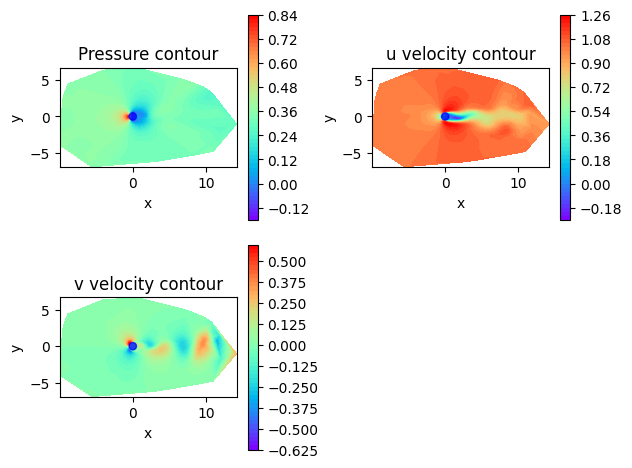

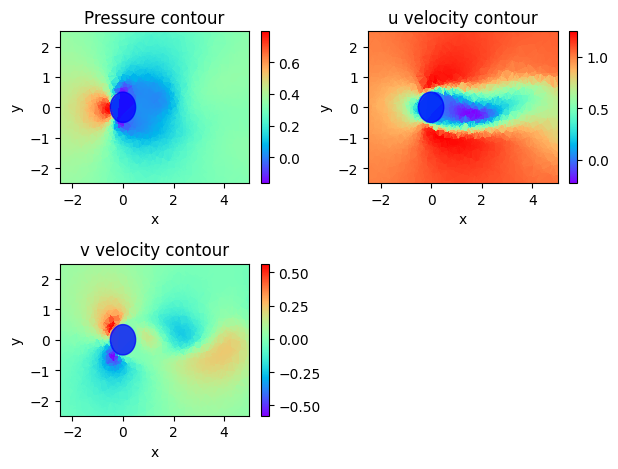

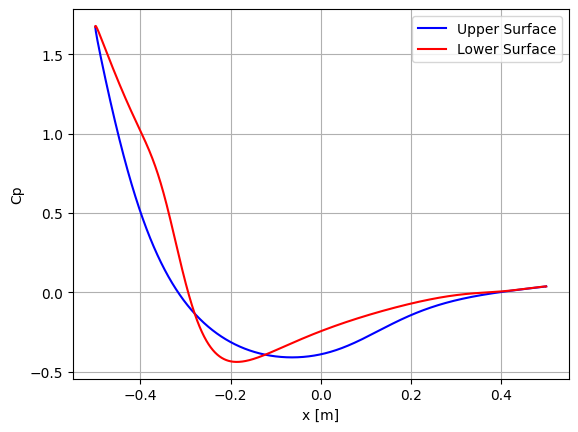

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle

## Try saving model state??

torch.save(test.model.state_dict(), "model_data_lim_new_BC.txt")
def pressure_distribution(r, x0, y0, model):
    d = 0.001
    theta_u = np.arange(0, np.pi+d, d)
    theta_l = np.arange(np.pi, 2*np.pi+d, d)
    x_u = (r * np.cos(theta_u) + x0)
    y_u = (r * np.sin(theta_u) + y0)

    x_l = (r * np.cos(theta_l) + x0)
    y_l = (r * np.sin(theta_l) + y0)

    xy_u = np.column_stack([x_u, y_u])
    xy_l = np.column_stack([x_l, y_l])
    X_u = torch.Tensor(xy_u)
    X_l = torch.Tensor(xy_l)
    preds_u = model(X_u)
    preds_l = model(X_l)

    p_u = preds_u[:, 2:3]     #pressure
    p_np_u   = p_u.detach().numpy()

    p_l = preds_l[:, 2:3]
    p_np_l = p_l.detach().numpy()


    cp_u = p_np_u/(0.5*rho0*u0**2)
    cp_l = p_np_l/(0.5*rho0*u0**2)


    return cp_u, cp_l, xy_u, xy_l

X, BC_X, BC_Y = Uniform_with_Cylinder(u0)
    
X = X.clone().detach().requires_grad_(True)      

# Test: Create new PINN instance and load the model
new = PINN()
new.model.load_state_dict(torch.load("model_data_lim_new_BC.txt")) # This is the model that has been trained in the above sections


# forward pass of the model !!! fwd pass outside eval/inference is okay as long as you dont .backward()
# we have to call .model() because our model is nested inside class PINN
# y_preds = test.model(X)
y_preds = new.model(X)

# Trying to save model state to a text file --- it works!


u = y_preds[:, 0:1]   # u velocity
v = y_preds[:, 1:2]
p = y_preds[:, 2:3]     #pressure


# convert to array for postprocessing
p_np   = p.detach().numpy()
u_np   = u.detach().numpy()
v_np   = v.detach().numpy()
x_np   = X[:, 0:1].detach().numpy()
y_np   = X[:, 1:2].detach().numpy()

# create data points to plot a circle on the plots
xc,yc, r = 0,0,0.5
theta = np.linspace(0, 2*np.pi, 400)
cylinder_x = (r * np.cos(theta) + xc)
cylinder_y = (r * np.sin(theta) + yc)


def tricontour(gs, x, y, z, title):
    """
    this is an explanation for tripcontour() and tripplot() which are two different methods for plotting contour type plots

    Args:
        grid: plot position in subplot
        x: x-array (x coords)
        y: y-array  (y coords)
        z: z-array (engineering value at [x,y])
        title: title 
    """
    plt.subplot(gs)
    tcf = plt.tricontourf(x, y, z, levels=50, cmap='rainbow')
    # Add the circle
    plt.fill(cylinder_x,cylinder_y, color='blue', alpha=0.75)
    plt.colorbar(tcf)
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    

# note we have to squeeze the arrays as they are in column vector format(ML format)
gs = GridSpec(2,2)
tricontour(gs[0,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(p_np), 'Pressure contour')
tricontour(gs[0,1], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(u_np), 'u velocity contour')
tricontour(gs[1,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(v_np), 'v velocity contour')
plt.tight_layout()
plt.show()


def tripplot(gs, x, y, z, title):
    plt.subplot(gs)
    plt.tripcolor(x, y, z, cmap='rainbow')
    
    # Add the circle
    plt.fill(cylinder_x,cylinder_y, color='blue', alpha=0.75)
    
    plt.ylim(-2.5,2.5)
    plt.xlim(-2.5,5)
    plt.colorbar()
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')

gs2 = GridSpec(2,2)
tripplot(gs2[0,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(p_np), 'Pressure contour')
tripplot(gs2[0,1], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(u_np), 'u velocity contour')
tripplot(gs2[1,0], np.squeeze(x_np), np.squeeze(y_np), np.squeeze(v_np), 'v velocity contour')
plt.tight_layout()
plt.show()

# Get pressure distribution for cylinder
cp_u, cp_l, xy_u, xy_l = pressure_distribution(0.5, 0, 0, new.model)
# Plot stuff
x_u = xy_u[:,0]
y_u = xy_u[:,1]

x_l, y_l = xy_l[:,0], xy_l[:,1]

plt.figure()
plt.plot(x_u, cp_u, '-b', label="Upper Surface")
plt.plot(x_l, cp_l, '-r', label="Lower Surface")
plt.xlabel("x [m]")
plt.ylabel("Cp")
plt.legend()
plt.grid()
plt.show() 


[0.006581045221537352, 0.0032554680947214365, 0.0011021113023161888, 0.000107196370663587, 0.0001009268089546822, 0.0006698992219753563, 0.001256005372852087, 0.0015047992346808314, 0.0013839786406606436, 0.0010316666448488832, 0.0006153230788186193, 0.0002659148594830185, 5.627589416690171e-05, 7.569123567918723e-07, 6.736163777532056e-05, 0.00019788669305853546, 0.00033054035156965256, 0.0004183478595223278, 0.00043861192534677684, 0.00039299370837397873, 0.00030112563399598, 0.00019152622553519905, 9.264374239137396e-05, 2.5702369384816848e-05, 2.8481480285336147e-07, 1.325058110523969e-05, 5.112973303766921e-05, 9.533551201457158e-05, 0.0001285156176891178, 0.0001398230524500832, 0.00012732576578855515, 9.709942969493568e-05, 5.986878750263713e-05, 2.6789408366312273e-05, 5.877396233699983e-06, 7.276161539948589e-08, 7.216059202619363e-06, 2.1602822016575374e-05, 3.636642577475868e-05, 4.581387111102231e-05, 4.700224599218927e-05, 4.019729749416001e-05, 2.8259453756618313e-05, 1.53

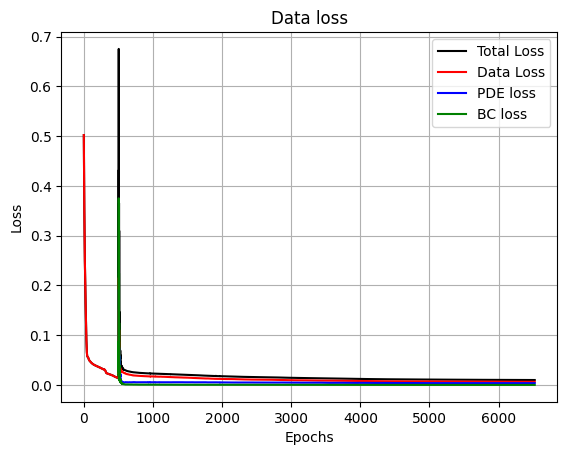

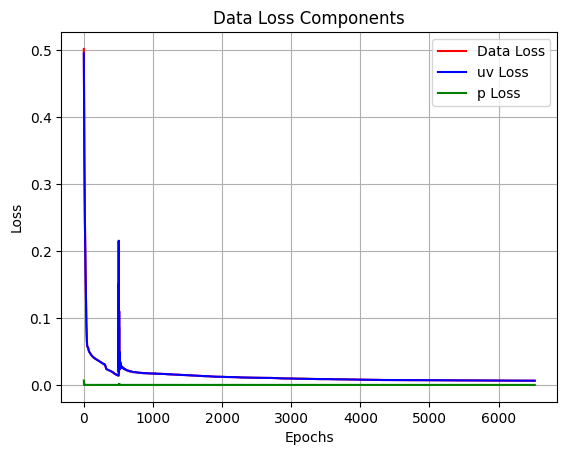

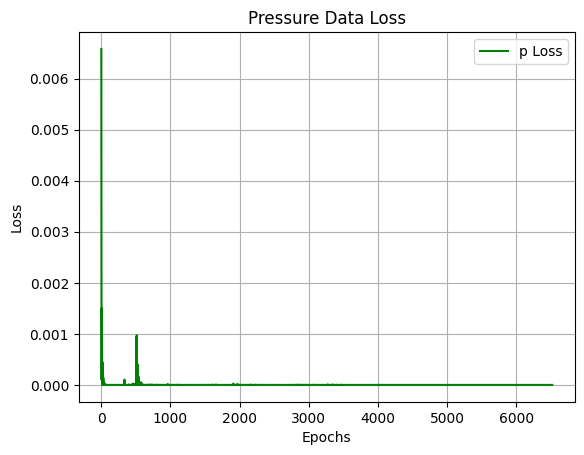

In [143]:
## Loss plots
epoch_split = 500

tot_loss = histories[0]
data_loss = histories[1]
uv_loss = histories[2]
p_loss = histories[3]
print(p_loss)
pde_loss = histories[4]
bc_loss = histories[5]
print(pde_loss)

""" print(data_loss)
print(data_loss[0].item()) """
epoch_total = epochs
x = np.arange(1, epoch_total, 1)
print(len(x), len(tot_loss))
x_split = np.where(x >= epoch_split)[0]


plt.figure()
plt.title("Data loss")
plt.plot(x, tot_loss, '-k', label="Total Loss")
plt.plot(x, data_loss, '-r', label="Data Loss")
""" plt.plot(x, uv_loss, '--r', label="uv Loss")
plt.plot(x, p_loss, '-.r', label="p Loss") """
plt.plot(x[x_split], pde_loss, '-b', label="PDE loss")
plt.plot(x[x_split], bc_loss, '-g', label="BC loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

#Plot data loss breakdown
plt.figure()
plt.title("Data Loss Components")
plt.plot(x, data_loss, '-r', label="Data Loss")
plt.plot(x, uv_loss, '-b', label="uv Loss")
plt.plot(x, p_loss, '-g', label="p Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.title("Pressure Data Loss")
plt.plot(x, p_loss, '-g', label="p Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

